# <a id='toc1_'></a>[TWO MOONS DATASET EXPERIMENTS](#toc0_)

The purpose of this notebook will be to analyze the behavior of the networks on a toy task, namely: the two moons dataset. This dataset is a simple binary classification task, where the goal is to separate two half-moon shaped clusters. The dataset is generated using the `make_moons` function from `sklearn.datasets`.

We want to see if the network manages to have uncertainty in the regions where the two moons are close to each other, and if it is able to correctly classify the points in the two moons.

This experiment will be conducted on both Deep Neural Networks (DNNs) and Binary Neural Networks (BiNNs).

**Table of contents**<a id='toc0_'></a>    
- [TWO MOONS DATASET EXPERIMENTS](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Train / test split](#toc1_2_)    
  - [Global variables](#toc1_3_)    
  - [Deep Neural Network](#toc1_4_)    
    - [Configuration and training of the network](#toc1_4_1_)    
    - [Exploiting the results](#toc1_4_2_)    
  - [Binary Neural Networks](#toc1_5_)    
    - [Configuration and training of the network](#toc1_5_1_)    
    - [Exploiting the results](#toc1_5_2_)    
    - [Straight Through Estimator with tanh](#toc1_5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)
Importing libraries and setting the global variables

In [15]:

from utils import *
from dataloader import *
import models
import torch
import trainer
from optimizer import *
from sklearn.datasets import make_moons
import palettable
from torch.utils.data import DataLoader, TensorDataset
from models.layers.activation import Sign

SEED = 0  # Random seed
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### SEED ###
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.set_default_device(DEVICE)
    torch.set_default_dtype(torch.float32)
np.random.seed(SEED)
torch.manual_seed(SEED)
    

## <a id='toc1_2_'></a>[Train / test split](#toc0_)

We split the dataset into a train and test set. The test set will be used to evaluate the performance of the network, while the train set will be used to train the network. We separate the data into:
- `x_train`: the input data for the training set with 1024 points
- `y_train`: the labels for the training set with 1024 points
- `x_test`: the input data for the test set with 256 points
- `y_test`: the labels for the test set with 256 points

In [16]:
tr_size = 250
te_size = 50

### CREATE TWO MOONS DATASET ###
X, y = make_moons(n_samples=tr_size+te_size, noise=0.1, random_state=SEED)

# normalize dataset
X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train = X[:tr_size]
y_train = y[:tr_size]
X_test = X[tr_size:]
y_test = y[tr_size:]

INPUT_SIZE = X_train.shape[1]

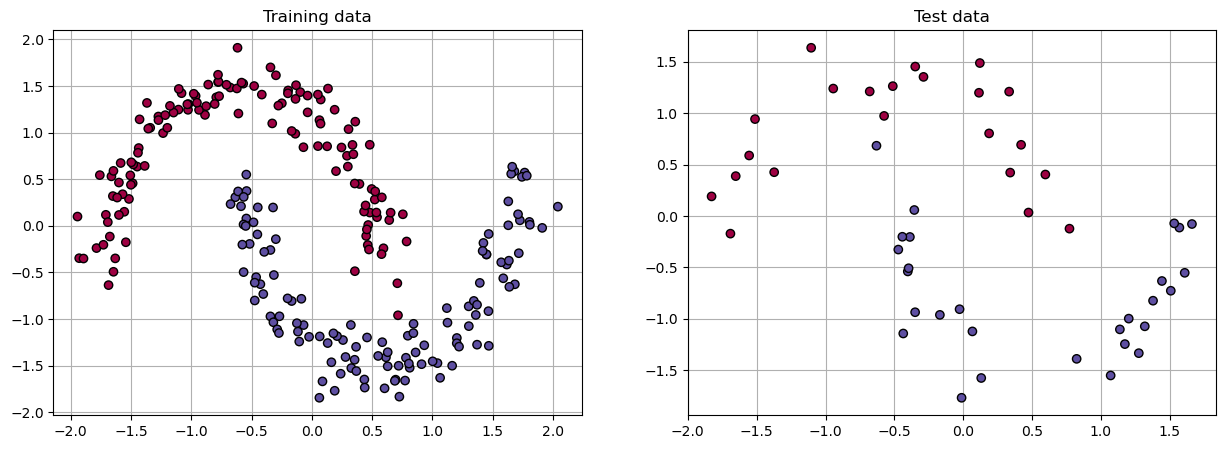

In [17]:
### PLOT X, y ###
# subplot for training data and test data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].grid(True)
ax[1].grid(True)
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[0].set_title("Training data")
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[1].set_title("Test data")
plt.show()

## <a id='toc1_3_'></a>[Global variables](#toc0_)

In [18]:

# Global parameters
SOFTMAX = True

LAYER_SIZE = [32, 32]
EPOCHS = 1000
BATCH_SIZE = tr_size
LEARNING_RATE = 10

if not SOFTMAX:
    SAVE_FOLDER = "saved-two-moons-2"
    OUT = 1
    OUTPUT_FUNCTION = None
    CRITERION = torch.functional.F.binary_cross_entropy_with_logits
else:
    SAVE_FOLDER = "saved-two-moons-softmax-2"
    OUT = 2
    OUTPUT_FUNCTION = "log_softmax"
    CRITERION = torch.functional.F.nll_loss

## <a id='toc1_4_'></a>[Deep Neural Network](#toc0_)

### <a id='toc1_4_1_'></a>[Configuration and training of the network](#toc0_)

We configure the network by setting the parameters within a dictionary.

In [19]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.BiNNBayesianNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "dropout": False, # Dropout layers
        "batchnorm": True, # Batch normalization layers
        "bias": False,
        "affine": False,
        "latent_weights": False, # Latent weights for BNN
        "activation_function": torch.functional.F.relu, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
        "lambda_init": 0,
        "n_samples": 1,
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
    },
    "criterion": CRITERION,
    "optimizer": BinaryMetaplasticUncertainty,
    "optimizer_parameters": {
        "lr": LEARNING_RATE,
        "gamma" :0,
        "n_samples": 1,
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.GPUTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Epoch 26/1000:   1%|▏         | 13/1000 [00:00<00:08, 120.99it/s, loss=0.285]

Testing accuracy: 
	Test accuracy: 28.00%
	Train accuracy: 74.00%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 24.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing ac

Epoch 54/1000:   4%|▍         | 40/1000 [00:00<00:07, 126.51it/s, loss=0.251]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing ac

Epoch 83/1000:   7%|▋         | 70/1000 [00:00<00:06, 138.11it/s, loss=0.244]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 95.60%
Testing ac

Epoch 111/1000:  10%|█         | 100/1000 [00:00<00:06, 140.68it/s, loss=0.232]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing ac

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.00%
Testing a

Epoch 165/1000:  16%|█▌        | 158/1000 [00:01<00:06, 134.17it/s, loss=0.196]

	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test acc

Epoch 192/1000:  19%|█▊        | 187/1000 [00:01<00:05, 136.15it/s, loss=0.2]  

	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test acc

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing

Epoch 245/1000:  24%|██▍       | 243/1000 [00:01<00:05, 133.08it/s, loss=0.202]

	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train a

Epoch 271/1000:  27%|██▋       | 271/1000 [00:02<00:05, 131.05it/s, loss=0.226]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing ac

Epoch 289/1000:  28%|██▊       | 285/1000 [00:02<00:06, 111.55it/s, loss=0.198]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing a

Epoch 318/1000:  31%|███▏      | 313/1000 [00:02<00:05, 123.68it/s, loss=0.19] 

	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train a

Epoch 344/1000:  34%|███▍      | 341/1000 [00:02<00:05, 127.28it/s, loss=0.19] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing a

Epoch 371/1000:  37%|███▋      | 369/1000 [00:02<00:04, 130.82it/s, loss=0.202]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing a

Epoch 398/1000:  40%|███▉      | 397/1000 [00:03<00:04, 133.90it/s, loss=0.214]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing a

Epoch 424/1000:  41%|████      | 411/1000 [00:03<00:04, 131.48it/s, loss=0.162]

	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train a

Epoch 451/1000:  44%|████▍     | 439/1000 [00:03<00:04, 131.21it/s, loss=0.175]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testin

Epoch 478/1000:  47%|████▋     | 468/1000 [00:03<00:04, 132.93it/s, loss=0.178]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing

Epoch 507/1000:  50%|████▉     | 498/1000 [00:03<00:03, 137.84it/s, loss=0.168]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testin

Epoch 563/1000:  56%|█████▌    | 556/1000 [00:04<00:03, 137.68it/s, loss=0.168]

	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train 

Epoch 592/1000:  58%|█████▊    | 585/1000 [00:04<00:02, 139.61it/s, loss=0.175]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testin

Epoch 618/1000:  61%|██████▏   | 613/1000 [00:04<00:02, 135.33it/s, loss=0.162]

	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing

Epoch 674/1000:  67%|██████▋   | 670/1000 [00:05<00:02, 137.24it/s, loss=0.168]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing 

Epoch 703/1000:  70%|███████   | 700/1000 [00:05<00:02, 138.57it/s, loss=0.171]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testin

Epoch 730/1000:  73%|███████▎  | 729/1000 [00:05<00:01, 136.57it/s, loss=0.189]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing

Epoch 756/1000:  74%|███████▍  | 743/1000 [00:05<00:01, 134.71it/s, loss=0.159]

	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Tes

Epoch 783/1000:  77%|███████▋  | 771/1000 [00:05<00:01, 132.60it/s, loss=0.158]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing

Epoch 811/1000:  80%|████████  | 801/1000 [00:06<00:01, 137.35it/s, loss=0.157]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing ac

Epoch 838/1000:  83%|████████▎ | 829/1000 [00:06<00:01, 135.38it/s, loss=0.161]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing

Epoch 866/1000:  86%|████████▌ | 858/1000 [00:06<00:01, 135.51it/s, loss=0.153]

	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train acc

Epoch 894/1000:  89%|████████▊ | 887/1000 [00:06<00:00, 135.93it/s, loss=0.175]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing 

Epoch 921/1000:  92%|█████████▏| 915/1000 [00:06<00:00, 135.20it/s, loss=0.164]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing 

Epoch 946/1000:  94%|█████████▍| 943/1000 [00:07<00:00, 131.30it/s, loss=0.173]

	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train ac

Epoch 974/1000:  97%|█████████▋| 972/1000 [00:07<00:00, 133.30it/s, loss=0.164]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testin

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:07<00:00, 134.03it/s, loss=0.168]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.60%
Testin

### <a id='toc1_4_2_'></a>[Exploiting the results](#toc0_)

In [20]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors

    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(name=name,
                                             colors=[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap
custom_map = custom_div_cmap(
    11, mincol='#86C29C', midcol='0.9', maxcol='#F5D752')

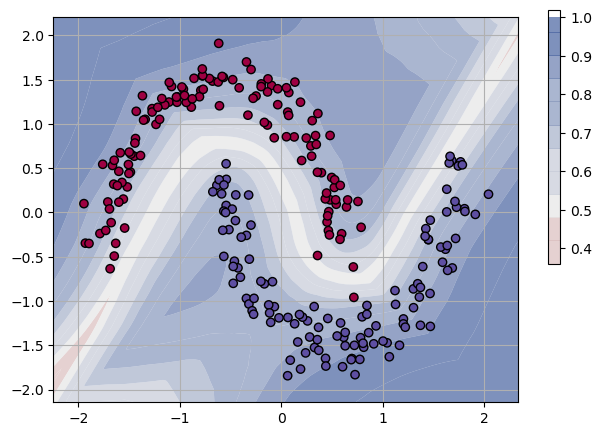

In [21]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
N_TEST_SAMPLES = 5
clevels = 9
network.n_samples = N_TEST_SAMPLES

prediction = []
for i in range(N_TEST_SAMPLES):
    prediction.append(network.predict(grid))
Z = torch.stack(prediction, dim=0)
Z = Z.mean(dim=0)
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = torch.sigmoid(Z).cpu().reshape(xx.shape)
else:
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()

### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-DNN-mean.pdf"), bbox_inches='tight')
plt.show()
